# 금융 데이터의 기술적 분석 02
### Technical Analysis

<img width="50%" src="http://i.imgur.com/OsG5rlF.jpg">

#### 2016-2019 [FinanceData.KR](http://financedata.kr)

In [0]:
#for Google Colab
!pip install -q finance-datareader

In [0]:
import matplotlib as mpl
mpl.style.use('classic')

In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import FinanceDataReader as fdr

# 값 설정
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [4]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2017, 6, 30)

# KB금융(105560)
df = fdr.DataReader("105560", start, end)
df = df[['Close', 'Volume']]
df.head()

,Close,Volume
Date,,
2017-01-02,42600,345769
2017-01-03,43700,956685
2017-01-04,44150,831295
2017-01-05,42800,1128957
2017-01-06,42650,1338299


# 라인 차트 - 가격

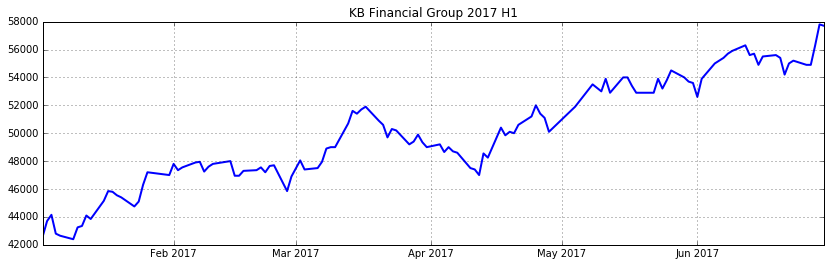

In [5]:
plt.title ('KB Financial Group 2017 H1')
plt.plot(df['Close'])
plt.show()

# 라인 차트 - 거래량

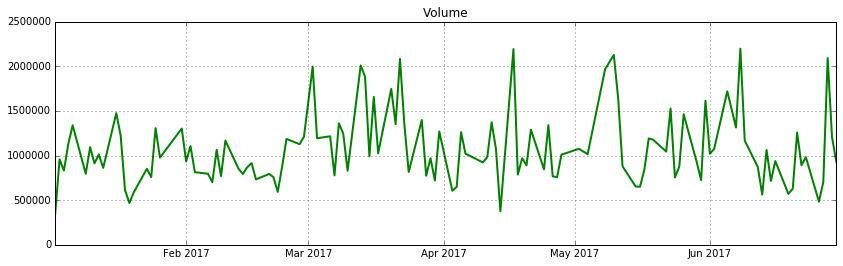

In [6]:
plt.title ('Volume')
plt.plot(df['Volume'], color='g')
plt.show()

# 가격과 거래량

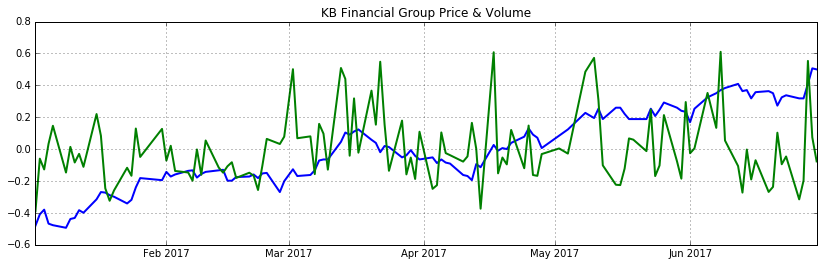

In [7]:
# min-max normaization
df_norm = (df - df.mean()) / (df.max() - df.min())

plt.title ('KB Financial Group Price & Volume')
plt.plot(df_norm)
plt.show()

# 바 차트 (거래량)

<BarContainer object of 122 artists>

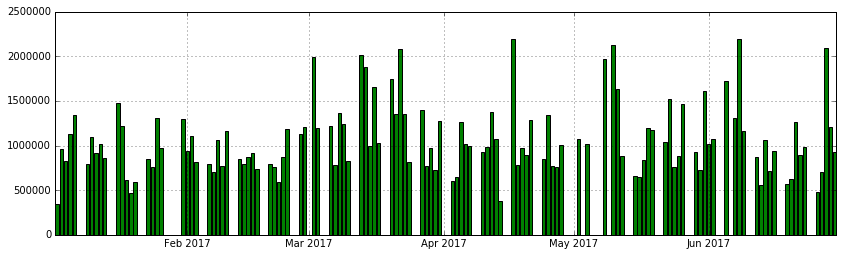

In [8]:
plt.bar(df.index.to_pydatetime(), df['Volume'], color='g')

# 이동평균
## 활용
* 이동평균(MA, moving average): 특정 구간의 평균치를 이은 선
* 주가의 불규칙성을 완화하는데 사용

## 기간별 분류
장기일수록 추세는 정확하나 후행성이 커짐

* 단기추세: 5일 이동평균선 
* 중기추세: 20일, 60일 이동평균선
* 장기추세: 120일, 200일 이동평균선

In [9]:
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df.dropna().head()

,Close,Volume,MA_5,MA_20
Date,,,,
2017-01-31,47000,1302205,46070.0,44547.5
2017-02-01,47800,933659,46680.0,44807.5
2017-02-02,47350,1106002,47130.0,44990.0
2017-02-03,47550,813522,47380.0,45160.0
2017-02-06,47900,795711,47520.0,45415.0


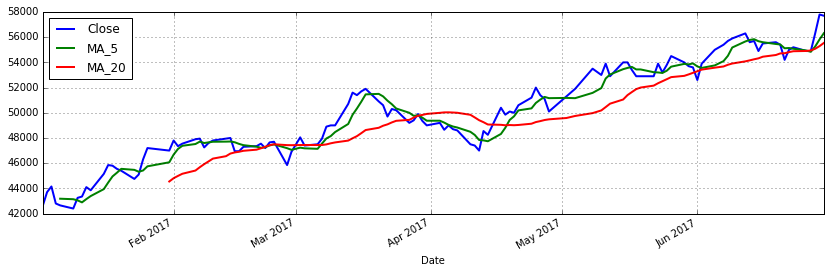

In [10]:
df[['Close', 'MA_5', 'MA_20']].plot()

# 이동평균선 분석법

## 정배열과 역배열
* 정배열 : 하단부터 장기, 중기, 단기 이동평균 선이 존재 (상승국면)
* 역배열 : 하단부터 단기, 중기, 장기 이동평균 선이 존재 (하락국면)

## 추세 전환
* "단기 → 장기"순으로 주가의 이동평균값이 움직임

    

# 골든크로스, 데드크로스

##  골든크로스(Golden cross)
* 단기이동평균선이 중장기이동평균선을 상향돌파(크로스)하는 것.
* 즉, 5일선이 20일선을, 20일선이 60일선을, 60일선이 120일선을 돌파할 때

## 데드크로스 (Dead cross)
* 단기 이동평균선이 중장기이동평균선을 하향돌파 하는 것
* 즉, 5일선이 20일선을, 20일선이 60일선을, 60일선이 120일선을 하향 돌파

## 계산법
* 단기와 장기 이동평균의 차이값(MA_5 - MA_20)를 비교
* 크로스(즉, 이전 값과 부호가 바뀌는 경우): (차이값 X 이전 차이값) < 0 

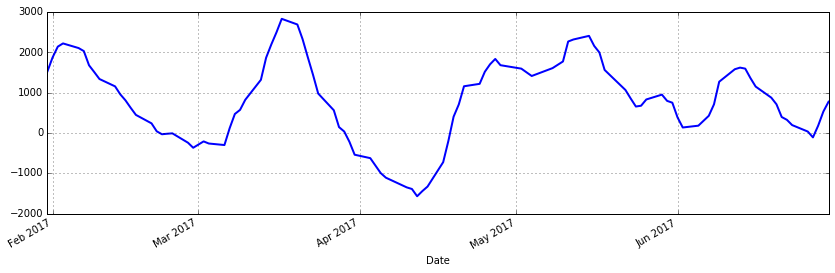

In [11]:
df['diff'] = df['MA_5'] - df['MA_20']
df['diff'].dropna().plot()

In [12]:
#  (이전 차이값 X 차이값 ) < 0: 이전 값과 부호가 바뀐 경우 
cross = df['diff'].shift(1) * df['diff'] < 0
df['diff'][cross == True]

Date
2017-02-22    -32.5
2017-03-07    117.5
2017-03-30   -220.0
2017-04-19    402.5
2017-06-27   -110.0
2017-06-28    180.0
Name: diff, dtype: float64

In [0]:
# 'cross' 컬럼을 추가하여, diff의 부호가 이전과 달라지는 경우 각각 저장
# 이때, 현재 diff > 0 이면, 골든 크로스, diff < 0 이면, 데드 크로스, 
df['cross'] = ''
df.loc[(df['diff'].shift(1) * df['diff'] < 0) & (df['diff'] > 0), 'cross'] = 'golden'
df.loc[(df['diff'].shift(1) * df['diff'] < 0) & (df['diff'] < 0), 'cross'] = 'dead'

In [14]:
df[df['cross'] != '']

,Close,Volume,MA_5,MA_20,diff,cross
Date,,,,,,
2017-02-22,47200,592610,47270.0,47302.5,-32.5,dead
2017-03-07,47950,777078,47560.0,47442.5,117.5,golden
2017-03-30,49350,720512,49610.0,49830.0,-220.0,dead
2017-04-19,50100,969663,49430.0,49027.5,402.5,golden
2017-06-27,54900,702481,54840.0,54950.0,-110.0,dead
2017-06-28,56300,2091508,55260.0,55080.0,180.0,golden


# 볼린저 밴드 Bollinger Bands 

## 개요
* 존 볼린저가 1980년대에 개발한 기술적분석 도구
* 이동평균선을 중심으로 주가가 움직일 수 있는 범위를 작성
* 추세장과 박스권 모든 경우에 사용할 수 있어서 효과적

## 구성
볼린저 밴드(20일, 2$\sigma$) 설정의 경우
* 중심선: 20일 이동평균선
* 상단선: 20일 이동평균선 + 표준편차x2
* 하단선: 20일 이동평균선 - 표준편차x2

In [0]:
def plot_bol_band_df(sym, start, end, n=20, k=2):
    df = fdr.DataReader(sym, start, end)

    df['MA_20'] = df['Close'].rolling(window=n).mean()
    df['BOL_UPPER'] = df['Close'].rolling(window=n).mean() + k * df['Close'].rolling(window=n).std()
    df['BOL_LOWER'] = df['Close'].rolling(window=n).mean() - k * df['Close'].rolling(window=n).std()
    df[['Close', 'MA_20', 'BOL_UPPER', 'BOL_LOWER' ]].plot(color=list('brgg'))
    plt.fill_between(df.index, df.loc[:, 'BOL_UPPER'].values, df.loc[:, 'BOL_LOWER'].values, facecolor='g', alpha=0.2)


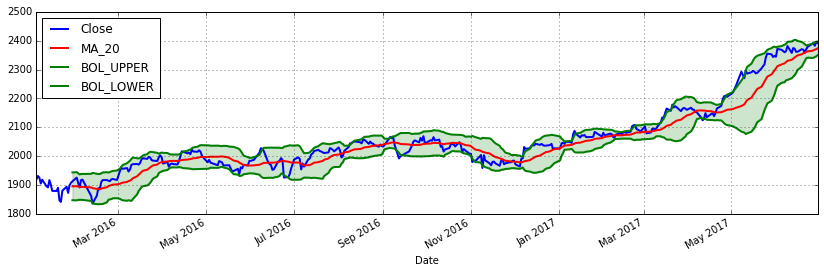

In [16]:
# 코스피 지수
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2017, 6, 30)

plot_bol_band_df('KS11', start, end)

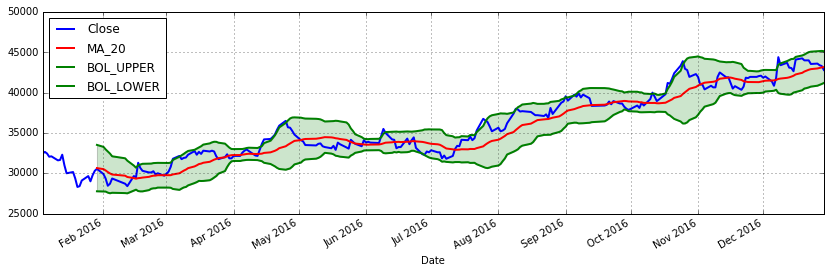

In [17]:
# KB금융그룹

start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2016, 12, 30)

plot_bol_band_df('105560', start, end)

# 볼린져밴드 매매 기법
* 주가가 일정기간 크게 변하지 않음 : 표준편차 작음
* 주가가 상승하거나 하락하는 추세 : 표준편차 커짐

## 매매 기법
* 볼린저 밴드가 넓을때 - 하부선 도달 시 매수, 상부선 도달 시 매도
* 볼린져 밴드가 좁을때 - 하부선 돌파 시 매도, 상부선 돌파 시 매수

주가가 볼린져밴드 범위밖으로 나갔다가 들어올때
* 상부선으로 회귀 시 매도, 하부선으로 회귀 시 매수

# 주가관련지표 개념과 종류
주가 등락의 일정한 사이클을 파악하기 위해 만들어진 것

1) 차이 지표
* 모멘텀(momentum): 특정 기간전의 주가와 차이
* ROC (Rate of Change): 주가 변화의 속도
* 이격도(disparity): 이동평균에서 벗어난 정도
* MACD (Moving Average Convergence Divergence): 장단기 이동평균선간의 차이

2) 표준화 지표
* 스토캐스틱
* CCI

3) 방향성 지표
* 투자심리선
* RSI

# 모멘텀 (Momentum)

* 모멘텀(0 기준) = 현재의 주가 - n일전 주가
* 모멘텀(100 기준) = (현재의 주가 / n일전 주가) * 100

과거 일정 시점 가격과 현재 가격을 비교, 현재 가격이 상승 혹은 하락 추세에 있는지 판단

In [0]:
def plot_momentum(sym, start, end, n = 10):
    df = fdr.DataReader(sym, start, end)
    col_name = 'MMT_' + str(n)
    df[col_name] = df['Close'].diff(n)

    df[['Close', col_name]].plot(secondary_y=['Close'])


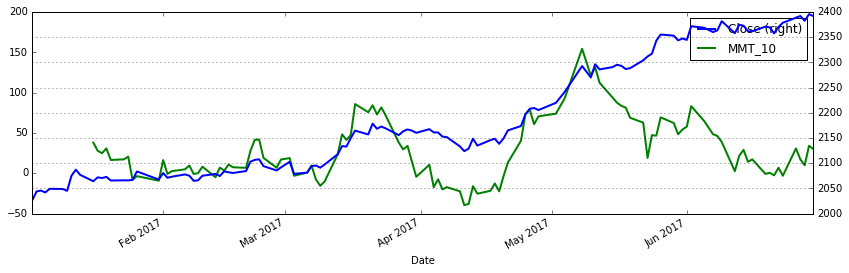

In [19]:
plot_momentum('KS11', '2017-01-01', '2017-06-30')

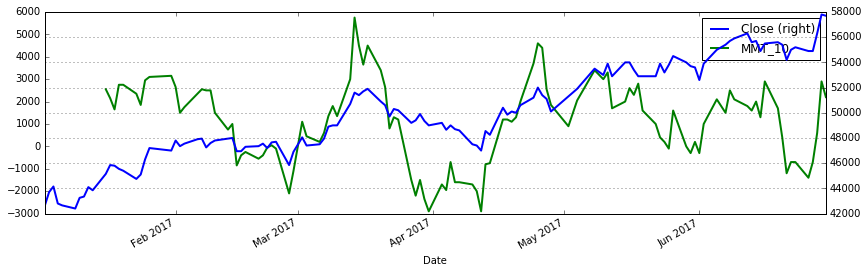

In [20]:
plot_momentum('105560', '2017-01-01', '2017-06-30')

# ROC (Rate of Change)
* ROC = (당일 주가 - n일전 주가) / n일전 주가
* 주가 변화의 속도를 알아보는 지표
* 0 이상이면 상승추세, 0이하면 하락 추세

In [0]:
def plot_ROC(sym, start, end, n = 12):
    df = fdr.DataReader(sym, start, end)
    col_name = 'ROC_' + str(n)
    df[col_name] = df['Close'].diff(n) / df['Close'].shift(n)

    df[['Close', col_name]].plot(secondary_y=['Close'])

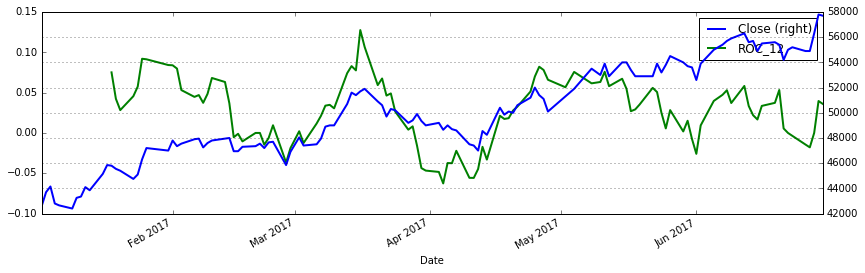

In [22]:
plot_ROC('105560', '2017-01-01', '2017-06-30')

# 이격도 (Disparity)
* 당일의 주가가 주가 이동평균선으로부터 벗어난 정도
* n일 이격도 = (현재 주가 / n일 이동평균) x 100

매매 전략 예시 (20일 이격도 기준)
* 이격도 95%이하 매수
* 이격도 105% 이상 매도

In [0]:
def plot_disparity(sym, start, end, n = 20):
    df = fdr.DataReader(sym, start, end)
    df['Disparity'] = df['Close'] / df['Close'].rolling(window=n).mean() * 100

    df[['Close', 'Disparity']].plot(secondary_y=['Close'])

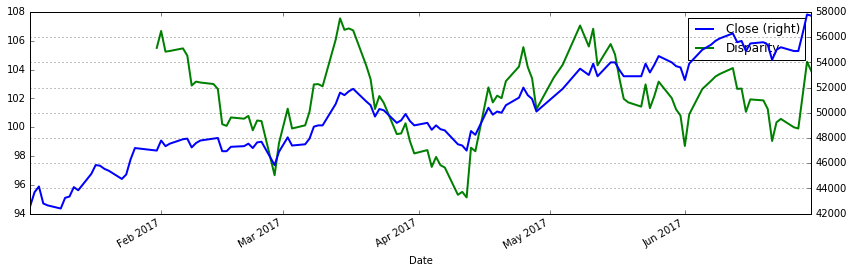

In [24]:
plot_disparity('105560', '2017-01-01', '2017-06-30')

# MACD
이동 평균선의 수렴과 확산을 나타내 주는 지표

기본공식
* MACD = 단기이동평균(12일) - 장기 이동평균(26일)
* 시그널 = MACD의 9일 이동평균

매매 전략 (예시)
* MACD가 양으로 증가하면 매수
* MACD가 시그널을 골든 크로스하면 매수
* MACD가 0선을 상향돌파하면 매수

In [0]:
def plot_macd(sym, start, end, nslow=26, nfast=12, c=9):
    df = fdr.DataReader(sym, start, end)

    df['EMA_FAST'] = df['Close'].ewm(span=nfast).mean()
    df['EMA_SLOW'] = df['Close'].ewm(span=nslow).mean()
    df['MACD'] = df['EMA_FAST']  -  df['EMA_SLOW'] 
    df['SIGNAL'] = df['MACD'].ewm(span=c).mean()

    plt.plot(df.index, df['MACD'] , color='red', lw=2)
    plt.plot(df.index,  df['SIGNAL'], color='green', lw=1)
    plt.fill_between(df.index, df['MACD'] - df['SIGNAL'], 0, alpha=0.5, facecolor='blue', edgecolor='blue')

    df['Close'].plot(color='b', secondary_y=True)

# ewm 참고: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.ewm.html    

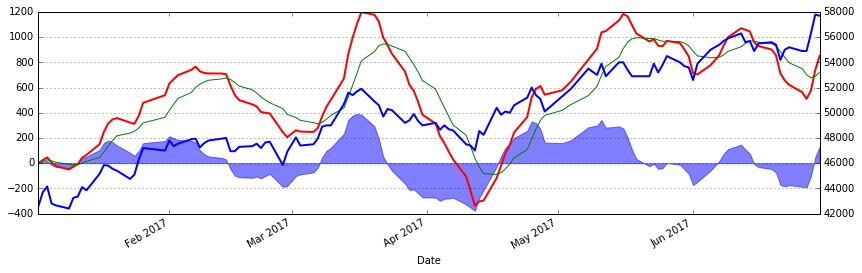

In [26]:
plot_macd('105560', '2017-01-01', '2017-06-30')

# 표준화 지표
기준값(평균 또는 최소값)을 차감한 후 변동지표로 나눈 것

## 스토캐스틱
* Stochastic Oscillator, 1950년대 William Dunnigun
* 현재 주가의 상대적 수준 파악하기 위한 지표
* %K선과 이의 이동평균선인 %D선으로 구성
 * %K = (금일 종가 - M일중 최저 종가) / (M일중 최고종가 - M일중 최저종가) x 100 
 * %D = N1 기간동안의 K 평균
        
## CCI
* Commodity Channel Indicator
* 이동평균에서 주가의 상대적 수준을 파악
* CCI = (Price  -  20-period SMA of Price) / (.015 x Mean Deviation)
* Typical Price (TP) = (High + Low + Close)/3
* Constant = .015

In [0]:
def plot_stochastic(sym, start, end):
    df = fdr.DataReader(sym, start, end)

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,8))
    plt.subplots_adjust(wspace=0, hspace=0.1)

    axes[0].plot(df.index, df['Close'])

    high = df['High'].rolling(window=5).max()
    low = df['Low'].rolling(window=5).min()
    df['K'] = 100 * (df['Close'] - low) / (high - low)
    df['D'] = df['K'].rolling(window=3).mean()

    axes[1].plot(df.index, df['K'], color='r', lw=2)
    axes[1].plot(df.index, df['D'], color='g', lw=1)

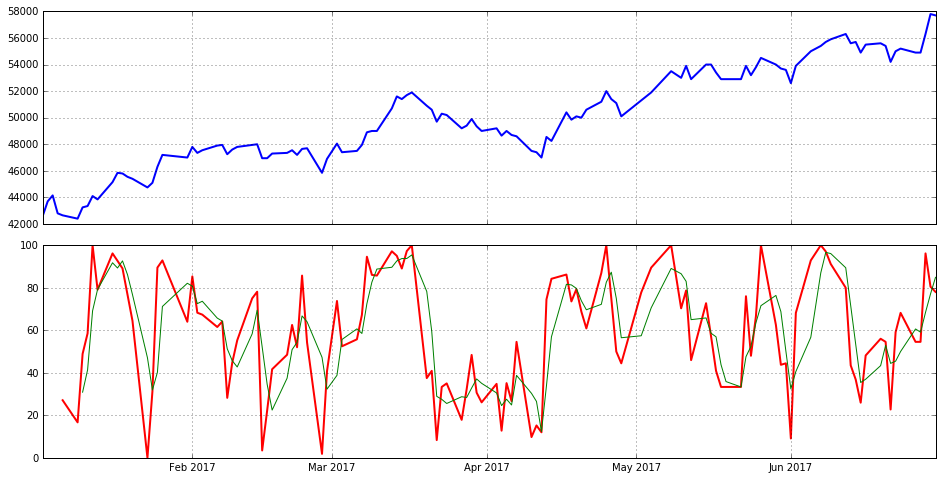

In [28]:
plot_stochastic('105560', '2017-01-01', '2017-06-30')

# 스토캐스틱 활용
* 주가의 추세전환: %K선과 %D선의 교차 및 일정 기준값의 교차
* 주가 상승 : %K가 70% 이상인 경우
* 주가 하락 : %K가 30% 이하인 경우
* %K가 %K의 이동평균선 %D(slow %K)의 교차로 상승 및 하락 신호로 파악

# 방향성 지표

## 투자심리선 (Psychological Line)
* 투자심리도 = ( 일정기간 중 주가 상승일수 / 기간값 ) x 100


## 상대강도지수(RSI)
* 추세가 가지는 강도를 객관적인 수치로 나타낸 지표
* n일 상승폭 합계 / (n일 상승폭 합계 + n일 하락폭 합계) × 100

# 투자심리선 (Psychological Line)
* 투자심리도 = ( 일정기간 중 주가 상승일수 / 기간값 ) x 100
* 기간값은 일반적으로 12일
* 0~100% 사이의 값
 * 75% 이상이면 과열권, 과열구간 진입 후 이탈 시 매도
 * 25% 이하이면 침체권, 침체구간 진입 후 이탈 시 매수

In [0]:
def plot_psychological(sym, start, end, n=12):
    df = fdr.DataReader(sym, start, end)

    df['전일대비등락'] = df['Close'] - df['Close'].shift(1)
    df['전일대비상승'] = 0
    df.loc[df['전일대비등락'] > 0, '전일대비상승'] = 1
    df['n일_상승_일수'] = df['전일대비상승'].rolling(window=n).sum()
    df['PSY'] = (df['n일_상승_일수'] / float(n)) * 100

    df[['Close', 'PSY']].plot(secondary_y=['Close'])

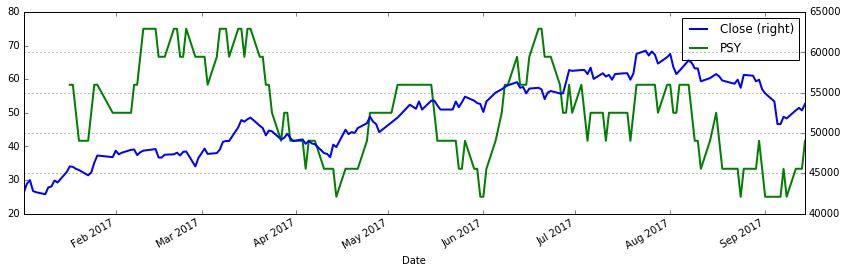

In [30]:
plot_psychological('105560', '2017-01-01', '2017-09-14')

# 상대강도지수(RSI)
추세가 가지는 강도를 객관적인 수치로 나타낸 지표

* RSI(Relative Strength Index), 1978년 Welles Wilder
* n일 상승폭 합계 / (n일 상승폭 합계 + n일 하락폭 합계) × 100
* RSI의 값은 0~100사이에서 결정
 * 30이하: 시장 침체(상승전환 예상)
 * 70이상: 시장과열(하락전환 예상)


In [0]:
def plot_RSI(sym, start, end, n=10):
    df = fdr.DataReader(sym, start, end)

    df['전일대비등락'] = df['Close'] - df['Close'].shift(1)

    df['전일대비상승폭'] = df[df['전일대비등락'] > 0]['전일대비등락']
    df['전일대비상승폭'] = df['전일대비상승폭'].fillna(0)

    df['전일대비하락폭'] = -df[df['전일대비등락'] < 0]['전일대비등락']
    df['전일대비하락폭'] = df['전일대비하락폭'].fillna(0)
    
    df['n일_상승폭_합계'] = df['전일대비상승폭'].rolling(window=n).sum()
    df['n일_하락폭_합계'] = df['전일대비하락폭'].rolling(window=n).sum()
    
    df['RSI'] = df['n일_상승폭_합계'] /  (df['n일_상승폭_합계'] +  df['n일_하락폭_합계'])* 100

    df[['Close', 'RSI']].plot(secondary_y=['Close'])

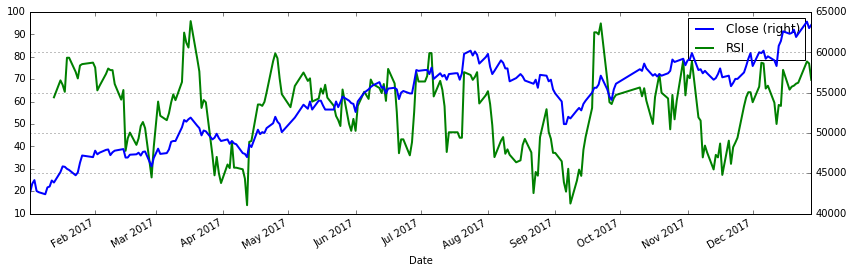

In [32]:
plot_RSI('105560', '2017-01-01', '2017-12-31')

# 거래량
거래량의 변화를 측정함으로써 매수 및 매도 강도 및 장세 등을 추정 (일반적으로 거래량은 주가 변화에 선행)

## OBV(On Balance Volume)
* 상승일의 거래량 합계에서 하락일의 거래량 합계을 차감시켜 표현

## VR(Volume Ratio)
* 일정기간의 주가 상승일의 거 래량 합과 하락일의 거래량합의 비율로 표현


## OBV(On Balance Volume)
* 상승일의 거래량 누계에서 하락일의 거래량을 차감시켜 표현
* 투자전략 예시
 * 주가 상승 + OBV 하락: 매도
 * 주가 하락 + OBV 상승: 매수
 * 주가 횡보 + OBV 보합: 관망

In [0]:
def plot_OBV(sym, start, end):
    df = fdr.DataReader(sym, start, end)

    df['전일대비등락'] = df['Close'] - df['Close'].shift(1)

    df['상승일_거래량'] = df[df['전일대비등락'] > 0]['Volume']
    df['상승일_거래량'] = df['상승일_거래량'].fillna(0)

    df['하락일_거래량'] = df[df['전일대비등락'] <= 0]['Volume']
    df['하락일_거래량'] = df['하락일_거래량'].fillna(0)
    
    df['n일_상승일_거래량_누계'] = df['상승일_거래량'].cumsum()
    df['n일_하락일_거래량_누계'] = df['하락일_거래량'].cumsum()
    
    df['OBV'] = df['n일_상승일_거래량_누계'] - df['n일_하락일_거래량_누계']
    df[['Close', 'OBV']].plot(secondary_y=['Close'])

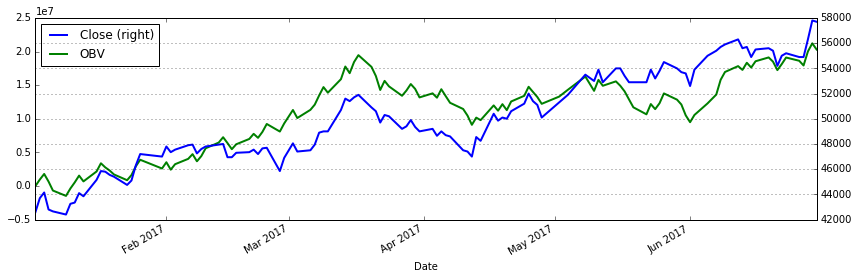

In [34]:
plot_OBV('105560', '2017-01-01', '2017-06-30')

#### 2016-2019 [FinanceData.KR](http://financedata.kr)